### MAST30034: Applied Data Science Project 1
---
# Data Analysis: Generating the Model for Trip Distances
#### Xavier Travers (1178369)

In this notebook, an Ordinary Least Squares linear model and a Gamma generalized linear regression are generated
on the additive model with interaction.

Trip distance is modelled against:
- Borough
- Preceding Week's index
- COVID-19 Case Rate (per 100'000 people)
    - Interaction with the Borough
- Influenza Case Rate (per 100'000 people)
    - Interaction with the Borough

In [1]:
# imports used throughout this notebook
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from statsmodels.genmod.families.family import Gamma
from statsmodels.graphics.api import abline_plot
import sys

# add homemade helpers
sys.path.insert(1, '../../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

# path where the data files are stored
DATA_PATH = '../../data'

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/21 10:38:53 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.18.201.145 instead (on interface eth0)
22/08/21 10:38:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 10:38:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/21 10:38:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# read in the aggregated covid data
covid_df = spark.read.parquet(f'{DATA_PATH}/curated/virals/covid/aggregated/cases_by_week')
covid_df.limit(5)

week_year,week_month,week_ending,week_index,borough,population,tot_cases,tot_pc_cases,tot_p100k_cases
2021,10,2021-10-09,93,Staten Island,493494.0,2830,0.005734618860614314,573.4618860614313
2020,7,2020-07-18,29,Staten Island,495522.0,825,0.001664910942400...,166.49109424001355
2021,7,2021-07-17,81,Staten Island,493494.0,1600,0.003242187341690...,324.2187341690071
2021,1,2021-01-16,55,Staten Island,493494.0,13390,0.027133055315768782,2713.3055315768784
2020,4,2020-05-02,18,Staten Island,495522.0,3380,0.006821089679166616,682.1089679166616


In [4]:
# read in the aggregated covid data
flu_df = spark.read.parquet(f'{DATA_PATH}/curated/virals/flu/aggregated/cases_by_week')
flu_df.limit(5)

week_year,week_month,week_ending,week_index,borough,population,tot_cases,tot_pc_cases,tot_p100k_cases
2020,6,2020-06-06,23,Bronx,1466438.0,0,0.0,0.0
2020,1,2020-01-18,3,Bronx,1466438.0,2331,0.00158956600960968,158.95660096096802
2020,8,2020-08-08,32,Bronx,1466438.0,0,0.0,0.0
2020,12,2020-12-26,52,Bronx,1466438.0,4,2.727698000188211...,0.2727698000188211
2020,7,2020-08-01,31,Bronx,1466438.0,0,0.0,0.0


In [5]:
# read in the aggregated yellow tlc data
tlc_pu_df = spark.read.parquet(f'{DATA_PATH}/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_trip_distance
2020,4,2020-05-02,18,Manhattan,1687834.0,55248,0.032733076831015374,3273.3076831015374,2.8488097306689624
2020,5,2020-05-30,22,Queens,2395791.0,4660,0.001945077846940739,194.5077846940739,9.020862660944168
2020,4,2020-05-02,18,Staten Island,495522.0,35,7.063258543515727E-5,7.063258543515727,23.470000000000002
2020,5,2020-05-23,21,Staten Island,495522.0,89,1.796085743922570...,17.960857439225705,24.68977528089888
2020,4,2020-04-04,14,Brooklyn,2727393.0,1556,5.705081739228634E-4,57.05081739228633,5.651150385604107


In [6]:
# join the datasets by week_index
joined_pu_df = jh.join_by_week_by_borough(tlc_pu_df, covid_df, 'covid')
joined_pu_df = jh.join_by_week_by_borough(joined_pu_df, flu_df, 'flu')

In [7]:
# check that the data doesn't look weird
joined_pu_df.limit(5)

22/08/21 10:39:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


week_year,week_month,week_ending,week_index,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_trip_distance,covid_week_year,covid_week_month,covid_week_ending,covid_week_index,covid_borough,covid_population,covid_tot_cases,covid_tot_pc_cases,covid_tot_p100k_cases,flu_week_year,flu_week_month,flu_week_ending,flu_week_index,flu_borough,flu_population,flu_tot_cases,flu_tot_pc_cases,flu_tot_p100k_cases
2020,4,2020-05-02,18,Manhattan,1687834.0,55248,0.032733076831015374,3273.3076831015374,2.8488097306689624,2020,4,2020-04-25,17,Manhattan,1687834.0,11320,0.006706820694452179,670.682069445218,2020,4,2020-04-25,17,Manhattan,1687834.0,0,0.0,0.0
2020,5,2020-05-30,22,Queens,2395791.0,4660,0.001945077846940739,194.5077846940739,9.020862660944168,2020,5,2020-05-23,21,Queens,2395791.0,8050,0.003360059370788...,336.00593707881865,2020,5,2020-05-23,21,Queens,2395791.0,0,0.0,0.0
2020,4,2020-05-02,18,Staten Island,495522.0,35,7.063258543515727E-5,7.063258543515727,23.470000000000002,2020,4,2020-04-25,17,Staten Island,495522.0,5525,0.011149858129406968,1114.9858129406969,2020,4,2020-04-25,17,Staten Island,495522.0,0,0.0,0.0
2020,5,2020-05-23,21,Staten Island,495522.0,89,1.796085743922570...,17.960857439225705,24.68977528089888,2020,5,2020-05-16,20,Staten Island,495522.0,1205,0.002431779012838...,243.1779012838986,2020,5,2020-05-16,20,Staten Island,495522.0,0,0.0,0.0
2020,4,2020-04-04,14,Brooklyn,2727393.0,1556,5.705081739228634E-4,57.05081739228633,5.651150385604107,2020,3,2020-03-28,13,Brooklyn,2727393.0,38960,0.014284703377914367,1428.4703377914368,2020,3,2020-03-28,13,Brooklyn,2727393.0,38,1.393271890042982...,1.3932718900429824


In [8]:
# remove all columns except those being fitted
joined_pu_df = joined_pu_df.select(
    F.col('avg_trip_distance'),
    (F.col('week_index') - 1).alias('pre_week_index'),
    F.col('pu_borough'),
    F.col('covid_tot_p100k_cases'),
    F.col('flu_tot_p100k_cases')
)

In [9]:
# convert the dataframe to pandas type
joined_pu_df = joined_pu_df.toPandas()

### OLS Linear Model

In [10]:
# generate the linear model as described above
gaussian_model = ols(
    formula = 'avg_trip_distance ~ pre_week_index + pu_borough * covid_tot_p100k_cases + pu_borough * flu_tot_p100k_cases',
    data = joined_pu_df
).fit()

In [12]:
# show summary information
print(gaussian_model.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_trip_distance   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1222.
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:39:04   Log-Likelihood:                -865.76
No. Observations:                 525   AIC:                             1764.
Df Residuals:                     509   BIC:                             1832.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [13]:
# generate an ANOVA table
table = sm.stats.anova_lm(gaussian_model, typ=2)
table

,sum_sq,df,F,PR(>F)
pu_borough,29011.342527,4.0,4437.938331,0.000000e+00
pre_week_index,113.623065,1.0,69.524829,7.098561e-16
covid_tot_p100k_cases,7.514132,1.0,4.597823,3.248551e-02
pu_borough:covid_tot_p100k_cases,4.567102,4.0,0.698641,5.931474e-01
flu_tot_p100k_cases,20.666797,1.0,12.645808,4.115448e-04
pu_borough:flu_tot_p100k_cases,450.519375,4.0,68.917087,1.313027e-46
Residual,831.848724,509.0,NaN,NaN


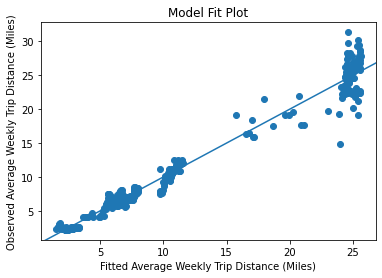

In [15]:
# show and plot the diagnostic observed vs fitted
ph.diagnostic_observed_fitted(joined_pu_df, gaussian_model, 'avg_trip_distance',
    'Average Weekly Trip Distance (Miles)')

### Gamma GLM

In [16]:
gamma_model = glm(
    formula = 'avg_trip_distance ~ pre_week_index + pu_borough * covid_tot_p100k_cases + pu_borough * flu_tot_p100k_cases',
    data = joined_pu_df,
    family = Gamma()
).fit()

/home/digitaldata/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [17]:
print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_trip_distance   No. Observations:                  525
Model:                            GLM   Df Residuals:                      509
Model Family:                   Gamma   Df Model:                           15
Link Function:          inverse_power   Scale:                       0.0081717
Method:                          IRLS   Log-Likelihood:                -542.18
Date:                Sun, 21 Aug 2022   Deviance:                       4.1847
Time:                        10:39:06   Pearson chi2:                     4.16
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

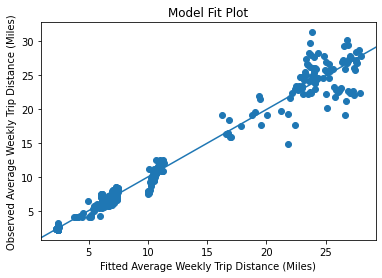

In [20]:
# show and plot the diagnostic observed vs fitted
ph.diagnostic_observed_fitted(joined_pu_df, gamma_model, 'avg_trip_distance',
    'Average Weekly Trip Distance (Miles)')